<a href="https://colab.research.google.com/github/SiHanWang2Developer/data/blob/master/%E7%AC%94%E7%94%BBaddPointRendnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

本文参考https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [4]:
!/opt/bin/nvidia-smi

Sun Mar 29 10:20:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install detectron2

In [0]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# import PointRend project
import sys; sys.path.insert(1, "detectron2_repo/projects/PointRend")
import point_rend

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# # download, decompress the data
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
# !unzip data.zip > /dev/null

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [0]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")

In [0]:
# fruits_nuts_metadata = MetadataCatalog.get("fruits_nuts")
# dataset_dicts = DatasetCatalog.get("fruits_nuts")

[03/26 02:56:00 d2.data.datasets.coco]: Loaded 18 images in COCO format from ./data/trainval.json




---


下面 笔画数据集



In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wz", {}, "./drive/My Drive/pic566_28class/images566.json", "./drive/My Drive/pic566_28class/images")

In [8]:
wanzheng_metadata = MetadataCatalog.get("wz")
wanzhengdataset_dicts = DatasetCatalog.get("wz")

[03/29 10:20:40 d2.data.datasets.coco]: Loading ./drive/My Drive/pic566_28class/images566.json takes 1.03 seconds.
[03/29 10:20:40 d2.data.datasets.coco]: Loaded 566 images in COCO format from ./drive/My Drive/pic566_28class/images566.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [0]:
# #坚果数据集
# import random

# for d in random.sample(dataset_dicts, 1):
#    img = cv2.imread(d["file_name"])#!!!!!!!!!!!!!!!!!！！！！！！！！！！！
#    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
#    vis = visualizer.draw_dataset_dict(d)
#    cv2_imshow(vis.get_image()[:, :, ::-1])
#    cv2_imshow(img)

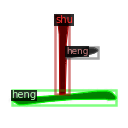

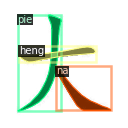

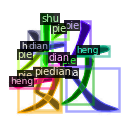

In [9]:
#笔画数据集
import random
for d in random.sample(wanzhengdataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=wanzheng_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [0]:
# from detectron2.engine import DefaultTrainer
# from detectron2.config import get_cfg
# import os

# cfg = get_cfg()
# cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# cfg.DATASETS.TRAIN = ("fruits_nuts",)
# cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.02
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()

# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)

cfg.merge_from_file("./drive/My Drive/Colab Notebooks/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("wz",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2

# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_3c3198.pkl"

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 28  # 28 classes (heng,shu....)




In [0]:
#正式训练
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("wz", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

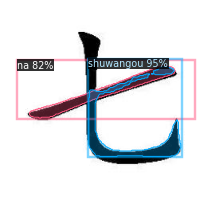

In [0]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(wanzhengdataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wanzheng_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels用于实例化可视化的不同颜色模式  IMAGE_BW：与IMAGE相同，但将所有不带遮罩的区域转换为灰度。仅适用于按实例绘制蒙版预测
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


    #如何输出单独的mask
    

In [0]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes
outputs["instances"]

In [0]:
wanzheng_metadata

Metadata(evaluator_type='coco', image_root='./drive/My Drive/pic566_28class/images', json_file='./drive/My Drive/pic566_28class/images566.json', name='wz', thing_classes=['piezhe', 'heng', 'hengzhewangou', 'pie', 'na', 'shuwangou', 'henggou', 'shugou', 'hengzhegou', 'hengzhezhezhegou', 'hengpie', 'shu', 'shuzhezhegou', 'dian', 'wangou', 'ti', 'shuti', 'shuzhe', 'wogou', 'hengzhe', 'xiegou', 'hengzhezhepie', 'hengzhewan', 'piedian', 'shuzhepie', 'hengxiegou', 'hengzheti', 'shuwan'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27})

We can also evaluate its performance using AP metric implemented in COCO API. This gives an AP of ~70%. Not bad!

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wz", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "wz")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[03/29 09:01:38 d2.data.datasets.coco]: Loaded 566 images in COCO format from ./drive/My Drive/pic566_28class/images566.json
[03/29 09:01:38 d2.data.common]: Serializing 566 elements to byte tensors and concatenating them all ...
[03/29 09:01:38 d2.data.common]: Serialized dataset takes 1.53 MiB
[03/29 09:01:38 d2.evaluation.evaluator]: Start inference on 566 images
[03/29 09:01:39 d2.evaluation.evaluator]: Inference done 11/566. 0.0609 s / img. ETA=0:00:35
[03/29 09:01:44 d2.evaluation.evaluator]: Inference done 85/566. 0.0623 s / img. ETA=0:00:32
[03/29 09:01:49 d2.evaluation.evaluator]: Inference done 158/566. 0.0627 s / img. ETA=0:00:28
[03/29 09:01:54 d2.evaluation.evaluator]: Inference done 229/566. 0.0629 s / img. ETA=0:00:23
[03/29 09:01:59 d2.evaluation.evaluator]: Inference done 304/566. 0.0627 s / img. ETA=0:00:18
[03/29 09:02:04 d2.evaluation.evaluator]: Inference done 374/566. 0.0632 s / img. ETA=0:00:13
[03/29 09:02:09 d2.evaluation.evaluator]: Inference done 447/566. 0.0

NameError: ignored

## Benchmark inference speed

In [0]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.07,fps:13.98
